In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
transform = transforms.ToTensor()

mnist_trainset = torchvision.datasets.MNIST(root='../datasets/MNIST/', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='../datasets/MNIST', train=False, download=True, transform=transform)

data_loading_params = {'batch_size': 16,
                       'shuffle': True,
                       'num_workers': 6
                      }

train_data = torch.utils.data.DataLoader(mnist_trainset, **data_loading_params)
test_data = torch.utils.data.DataLoader(mnist_testset, **data_loading_params)

In [3]:
class ConvNN(nn.Module):
    
    def __init__(self, channels, kernels, layers):
        super(ConvNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv2d(c, channels[i+1], k) for (i, c), k in zip(enumerate(channels[:-1]), kernels)])
        self.linear = nn.ModuleList([nn.Linear(v, layers[i+1]) for i, v in enumerate(layers[:-1])])
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
    
    
    def forward(self, x):
        for i, l in enumerate(self.conv):
            x = self.pool(
                F.relu(
                l(x)
            ))
        
        x = torch.flatten(x, 1)

        for i, l in enumerate(self.linear[:-1]):
            x = F.relu(l(x))

        x = self.softmax(self.linear[-1](x))

        return x

    def parameter_count(self):
        return sum(p.numel() for p in self.parameters())
        

def fit(model, train_data, criterion, optimizer, num_epochs=10):

    for epoch in tqdm(range(num_epochs), desc="Epochs", leave=False):
        for local_batch, local_labels in tqdm(train_data, desc="Batches", leave=False):
    
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                
            optimizer.zero_grad()
            loss = criterion(model(local_batch), local_labels)
    
            loss.backward()
            optimizer.step()

In [4]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, data_loader):

    y_true = []
    y_pred = []

    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += len(labels)

            nlabels = labels.data.cpu().numpy()
            predicted = predicted.data.cpu().numpy()
            
            y_pred.extend(predicted)
            y_true.extend(nlabels)

    cf_matrix = confusion_matrix(y_true, y_pred)
    acc = 100 * correct / total
    
    return cf_matrix, acc
            
        

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNN(
    channels=[1, 64, 128, 64], 
    kernels=[5, 3, 3], 
    layers=[64, 25, 10], 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

fit(model, train_data, criterion, optimizer)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

In [6]:
train_cf, train_acc = get_confusion_matrix(model, train_data)
test_cf, test_acc = get_confusion_matrix(model, test_data)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [7]:
print(train_acc, test_acc)

98.62333333333333 98.41


## Q4 - Comparing parameter count vs accuracy

In [8]:
small_model = ConvNN(
    channels=[1, 5, 3],
    kernels=[5, 3],
    layers=[75, 25, 10]
).to(device)

s_optimizer = torch.optim.Adam(small_model.parameters(), lr=0.001)

fit(small_model, train_data, criterion, s_optimizer)

train_cf_s, train_acc_s = get_confusion_matrix(small_model, train_data)
test_cf_s, test_acc_s = get_confusion_matrix(small_model, test_data)

print(f'Small model: num_params={small_model.parameter_count()}, train_acc={train_acc_s}, test_acc={test_acc_s}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Small model: num_params=2428, train_acc=96.44333333333333, test_acc=96.47


In [9]:
medium_model = ConvNN(
    channels=[1, 64, 128, 64], 
    kernels=[5, 3, 3], 
    layers=[64, 25, 10], 
).to(device)

m_optimizer = torch.optim.Adam(medium_model.parameters(), lr=0.001)

fit(medium_model, train_data, criterion, m_optimizer)

train_cf_m, train_acc_m = get_confusion_matrix(medium_model, train_data)
test_cf_m, test_acc_m = get_confusion_matrix(medium_model, test_data)

print(f'Medium model: num_params={medium_model.parameter_count()}, train_acc={train_acc_m}, test_acc={test_acc_m}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Medium model: num_params=151197, train_acc=98.06, test_acc=97.99


In [10]:
large_model = ConvNN(
    channels=[1, 128, 256, 64],
    kernels=[5, 3, 3],
    layers=[64, 25, 10]
).to(device)

l_optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

fit(large_model, train_data, criterion, l_optimizer)

train_cf_l, train_acc_l = get_confusion_matrix(large_model, train_data)
test_cf_l, test_acc_l = get_confusion_matrix(large_model, test_data)

print(f'Large model: num_params={large_model.parameter_count()}, train_acc={train_acc_l}, test_acc={test_acc_l}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Large model: num_params=447901, train_acc=95.77333333333333, test_acc=95.65


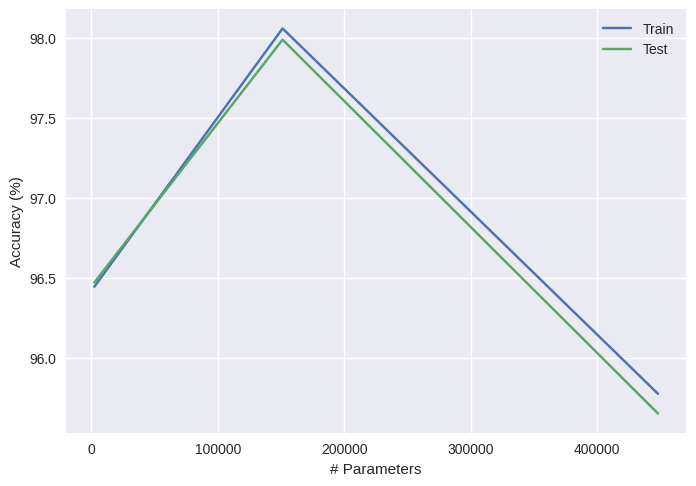

In [19]:
plt.plot([l.parameter_count() for l in [small_model, medium_model, large_model]], [train_acc_s, train_acc_m, train_acc_l], label="Train")
plt.plot([l.parameter_count() for l in [small_model, medium_model, large_model]], [test_acc_s, test_acc_m, test_acc_l], label="Test")
plt.legend()
plt.xlabel("# Parameters")
plt.ylabel("Accuracy (%)")
plt.show()